# PLOT 1: Q residuals vs. t_int for three altitudes - setting after peak altitude

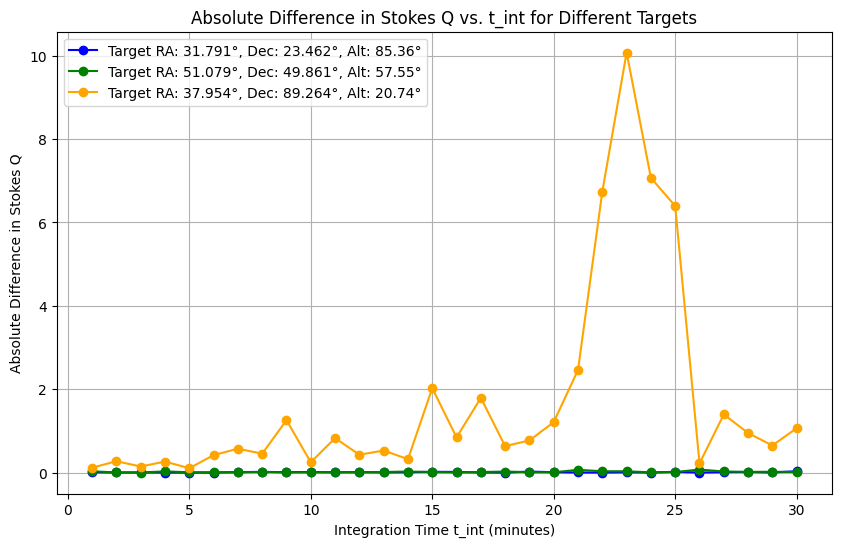

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm
import stokes

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Time intervals in seconds (1 to 10 minutes in 1-minute increments)
time_intervals = np.arange(1, 31) * 60  # Convert minutes to seconds
time_step_minutes = 1

# Colors for each target
colors = ['blue', 'green', 'orange']

# Plot data storage
q_differences = {i: [] for i in range(len(targets))}

# Run the simulation for each target and each time interval
for target_idx, target in enumerate(targets):
    Q_injected = 0.001  # Example injected polarization level in Stokes Q
    U_injected = 0
    injected_stokes = np.array([1, Q_injected, U_injected, 0])
    
    for t_int in time_intervals:
        # Run matrix inversion function with dynamic PA and altitude
        S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
            ra=target["ra"], 
            dec=target["dec"], 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude, 
            jd_str=observation_date, 
            ut_start=observation_time, 
            t_int=t_int, 
            Q=Q_injected, 
            U=U_injected, 
            delta_HWP=0.5
        )
        
        # Absolute difference for Q between injected and retrieved
        absolute_difference_Q = np.abs(injected_stokes[1] - S_in_retrieved[1])
        q_differences[target_idx].append(absolute_difference_Q)

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    altitude = angles.calculate_altitude(
        phi=observer_latitude, 
        delta=target["dec"], 
        H=angles.calculate_hour_angle(
            ra=target["ra"], 
            observer_longitude=observer_longitude, 
            ut=observation_time, 
            jd_str=observation_date
        )
    )
    plt.plot(time_intervals / 60, q_differences[target_idx], '-o', color=colors[target_idx],
             label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°, Alt: {altitude:.2f}°')

# Plot settings
plt.xlabel('Integration Time t_int (minutes)')
plt.ylabel('Absolute Difference in Stokes Q')
plt.title('Absolute Difference in Stokes Q vs. t_int for Different Targets')
plt.legend()
plt.grid(True)
plt.show()


# Printing total parallactic angle change

In [14]:
# Additional code to calculate parallactic angle change for each target at t_int = 10 mins (600 seconds)
t_int_max = time_intervals[-1]  # 10 minutes in seconds

print("\nParallactic Angle Change for max t_int:\n")
for target_idx, target in enumerate(targets):
    # Calculate initial and final parallactic angles for t_int = 10 mins
    pa_start = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=observation_time, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )
    
    # Calculate end time in UT after 10 minutes
    ut_start_hours, ut_start_minutes, ut_start_seconds = map(int, observation_time.split(":"))
    ut_start_decimal = ut_start_hours + ut_start_minutes / 60.0 + ut_start_seconds / 3600.0
    ut_end_decimal = ut_start_decimal + t_int_max / 3600.0
    ut_end = f"{int(ut_end_decimal // 1):02}:{int((ut_end_decimal % 1) * 60):02}:{int(((ut_end_decimal % 1) * 3600) % 60):02}"
    
    # Calculate final parallactic angle
    pa_end = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=ut_end, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )
    
    # Calculate and print the change in parallactic angle
    pa_change = pa_end - pa_start
    print(f"Target RA: {target['ra']}°, Dec: {target['dec']}°")
    print(f"Parallactic Angle Start: {pa_start:.2f}°, End: {pa_end:.2f}°, Change: {pa_change:.2f}°\n")



Parallactic Angle Change for max t_int:

Target RA: 31.791°, Dec: 23.462°
Parallactic Angle Start: -42.32°, End: -73.10°, Change: -30.77°

Target RA: 51.079°, Dec: 49.861°
Parallactic Angle Start: 28.80°, End: 15.73°, Change: -13.07°

Target RA: 37.954°, Dec: 89.264°
Parallactic Angle Start: 2.86°, End: -4.70°, Change: -7.56°



# PLOT 2: PLOT 1 with some noise

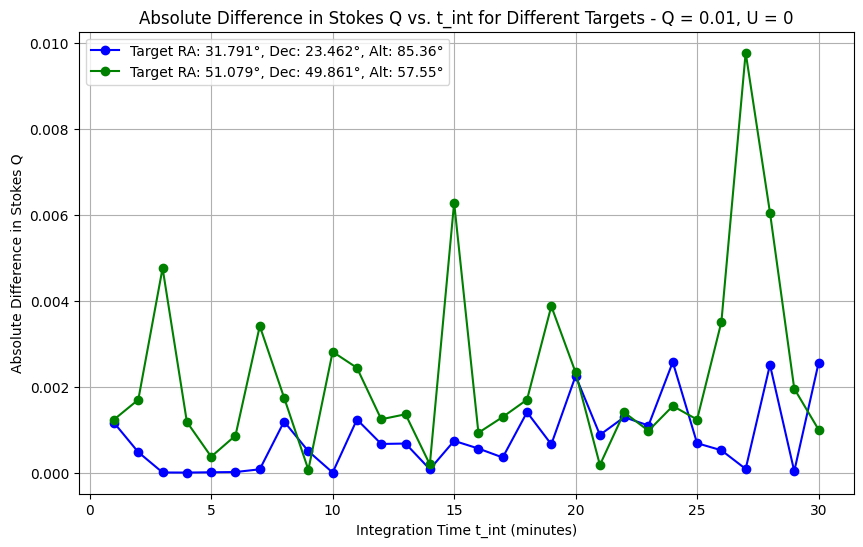

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm
import stokes

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Time intervals in seconds (1 to 10 minutes in 1-minute increments)
time_intervals = np.arange(1, 31) * 60  # Convert minutes to seconds
time_step_minutes = 1

# Colors for each target
colors = ['blue', 'green', 'orange']

# Plot data storage
q_differences = {i: [] for i in range(len(targets))}

# Run the simulation for each target and each time interval
for target_idx, target in enumerate(targets):
    Q_injected = 0.01  # Example injected polarization level in Stokes Q
    U_injected = 0
    injected_stokes = np.array([1, Q_injected, U_injected, 0])
    
    for t_int in time_intervals:
        # Run matrix inversion function with dynamic PA and altitude
        S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
            ra=target["ra"], 
            dec=target["dec"], 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude, 
            jd_str=observation_date, 
            ut_start=observation_time, 
            t_int=t_int, 
            Q=Q_injected, 
            U=U_injected, 
            delta_HWP=0.5,
            noise_percentage = 0.1
        )
        
        # Absolute difference for Q between injected and retrieved
        absolute_difference_Q = np.abs(injected_stokes[1] - S_in_retrieved[1])
        q_differences[target_idx].append(absolute_difference_Q)

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    altitude = angles.calculate_altitude(
        phi=observer_latitude, 
        delta=target["dec"], 
        H=angles.calculate_hour_angle(
            ra=target["ra"], 
            observer_longitude=observer_longitude, 
            ut=observation_time, 
            jd_str=observation_date
        )
    )
    plt.plot(time_intervals / 60, q_differences[target_idx], '-o', color=colors[target_idx],
             label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°, Alt: {altitude:.2f}°')

# Plot settings
plt.xlabel('Integration Time t_int (minutes)')
plt.ylabel('Absolute Difference in Stokes Q')
plt.title('Absolute Difference in Stokes Q vs. t_int for Different Targets - Q = 0.01, U = 0')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Additional code to calculate parallactic angle change for each target at t_int = t_int_max (600 seconds)
t_int_max = time_intervals[-1]  # 10 minutes in seconds

print("\nParallactic Angle Change for t_int Max:\n")
for target_idx, target in enumerate(targets):
    # Calculate initial and final parallactic angles for t_int = 10 mins
    pa_start = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=observation_time, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )
    
    # Calculate end time in UT after max t_int
    ut_start_hours, ut_start_minutes, ut_start_seconds = map(int, observation_time.split(":"))
    ut_start_decimal = ut_start_hours + ut_start_minutes / 60.0 + ut_start_seconds / 3600.0
    ut_end_decimal = ut_start_decimal + t_int_max / 3600.0
    ut_end = f"{int(ut_end_decimal // 1):02}:{int((ut_end_decimal % 1) * 60):02}:{int(((ut_end_decimal % 1) * 3600) % 60):02}"
    
    # Calculate final parallactic angle
    pa_end = angles.calculate_parallactic_angle(
        ra=target["ra"], 
        dec=target["dec"], 
        ut=ut_end, 
        jd_str=observation_date, 
        observer_latitude=observer_latitude, 
        observer_longitude=observer_longitude
    )
    
    # Calculate and print the change in parallactic angle
    pa_change = pa_end - pa_start
    print(f"Target RA: {target['ra']}°, Dec: {target['dec']}°")
    print(f"Parallactic Angle Start: {pa_start:.2f}°, End: {pa_end:.2f}°, Change: {pa_change:.2f}°\n")



Parallactic Angle Change for t_int Max:

Target RA: 31.791°, Dec: 23.462°
Parallactic Angle Start: -42.32°, End: -73.10°, Change: -30.77°

Target RA: 51.079°, Dec: 49.861°
Parallactic Angle Start: 28.80°, End: 15.73°, Change: -13.07°

Target RA: 37.954°, Dec: 89.264°
Parallactic Angle Start: 2.86°, End: -4.70°, Change: -7.56°

